In [1]:
import requests
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [10]:
import wandb
wandb.init(project="blip-2-adversaial-training", entity="capstone-project")

In [4]:
# ! pip install transformers
# ! pip install torchvision
# ! pip install wandb

In [2]:
import torch
from transformers import BlipProcessor, Blip2ForConditionalGeneration
device = "cuda" if torch.cuda.is_available() else "cpu"


MODEL_ID = "Salesforce/blip2-flan-t5-xl"
processor = BlipProcessor.from_pretrained(MODEL_ID)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'BertTokenizerFast'.


In [4]:
# by default `from_pretrained` loads the weights in float32
# we load in float16 instead to save memory
# # model = Blip2ForConditionalGeneration.from_pretrained(MODEL_ID, torch_dtype=torch.float16)
model = Blip2ForConditionalGeneration.from_pretrained(MODEL_ID)
model.to(device)

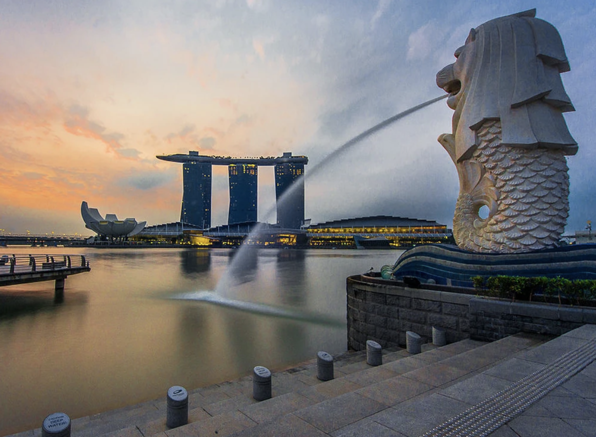

In [26]:
url = 'https://storage.googleapis.com/sfr-vision-language-research/LAVIS/assets/merlion.png'
input_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')
# input_img = torch.tensor(np.array(input_img) / 255.0, dtype=torch.float32, requires_grad=True)
display(input_img.resize((596, 437)))
input_img = torch.tensor(np.array(input_img) / 255.0)

In [27]:
def get_input_optimizer(input_img, learning_rate):
    # this line to show that input is a parameter that requires a gradient
    # optimizer = torch.optim.Adam([input_img], lr=learning_rate)
    optimizer = torch.optim.Adam([input_img], lr=learning_rate)
    return optimizer

In [28]:
# We also put the model in evaluation mode, so that specific layers
# such as dropout or batch normalization layers behave correctly.
model.eval()
model.requires_grad_(False)

learning_rate = 0.01

# Text prompt
prompt = "Question: name one object in the image? Answer:"
target_word_index = 13599

In [29]:
input_img.size()

torch.Size([874, 1192, 3])

In [30]:
# inputs = processor(input_img, text=prompt, return_tensors="pt").to(device, torch.float16)
inputs = processor(input_img, text=prompt, return_tensors="pt").to(device)

In [31]:
inputs['pixel_values'].size()

torch.Size([1, 3, 224, 224])

In [32]:
# inputs['pixel_values'].requires_grad=True
inputs['pixel_values'].requires_grad_(False)

tensor([[[[-1.7832, -1.7830, -1.7830,  ..., -1.7864, -1.7864, -1.7864],
          [-1.7830, -1.7831, -1.7830,  ..., -1.7863, -1.7865, -1.7866],
          [-1.7830, -1.7829, -1.7830,  ..., -1.7863, -1.7866, -1.7866],
          ...,
          [-1.7875, -1.7875, -1.7875,  ..., -1.7881, -1.7881, -1.7883],
          [-1.7875, -1.7875, -1.7877,  ..., -1.7885, -1.7883, -1.7884],
          [-1.7877, -1.7875, -1.7876,  ..., -1.7887, -1.7887, -1.7888]],

         [[-1.7426, -1.7424, -1.7424,  ..., -1.7440, -1.7441, -1.7441],
          [-1.7425, -1.7425, -1.7424,  ..., -1.7439, -1.7442, -1.7442],
          [-1.7424, -1.7423, -1.7424,  ..., -1.7439, -1.7442, -1.7442],
          ...,
          [-1.7481, -1.7482, -1.7481,  ..., -1.7474, -1.7473, -1.7474],
          [-1.7482, -1.7482, -1.7483,  ..., -1.7479, -1.7476, -1.7477],
          [-1.7483, -1.7480, -1.7475,  ..., -1.7481, -1.7481, -1.7481]],

         [[-1.4702, -1.4701, -1.4700,  ..., -1.4695, -1.4697, -1.4697],
          [-1.4701, -1.4701, -

In [33]:
change = torch.zeros_like(inputs['pixel_values']).to(device)
change.requires_grad = True

In [34]:
# optimizer = get_input_optimizer(inputs['pixel_values'], learning_rate)
optimizer = get_input_optimizer(change, learning_rate)

In [35]:
inputs['pixel_values'].max()

tensor(-1.4683, device='cuda:0')

In [36]:
delta = 0.1

In [37]:
deep_copy_tensor = inputs['pixel_values'].clone()

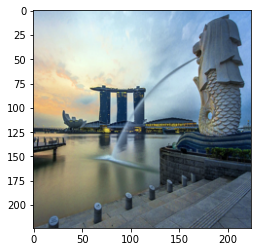

In [38]:
# optimized_image = inputs['pixel_values'].detach().cpu().numpy()
optimized_image = (inputs['pixel_values'] + change).detach().cpu().numpy()

# Scale each channel independently between 0 and 1
min_vals = optimized_image.min(axis=(2, 3), keepdims=True)
max_vals = optimized_image.max(axis=(2, 3), keepdims=True)
scaled_image = (optimized_image - min_vals) / (max_vals - min_vals)

# Plot the scaled image
plt.imshow(scaled_image.squeeze().transpose(1, 2, 0))
plt.show()

In [39]:
losses = []
torch.autograd.set_detect_anomaly(True)

In [41]:
inputs['decoder_input_ids'] = inputs['input_ids']

In [1]:
print('Optimizing..')
run = [0]
while True:
        
    inputs['pixel_values'] = deep_copy_tensor + change
    
    optimizer.zero_grad()
    
    outputs = model(**inputs)
    
    # Apply softmax to the logits
    logits = outputs.logits[0, 1:2, :]
    
    probabilities = torch.softmax(logits, dim=1)
    
    target_prob = probabilities[0, target_word_index]

    loss = -torch.log(target_prob)
    
    print('loss', loss)    
    
    # print(loss)
    losses.append(loss)
    
    if loss.item()<0.1:
        break

    loss.backward()

    run[0] += 1
    
    optimizer.step()

    with torch.no_grad():
        change[:] = change.clamp(-delta, delta)

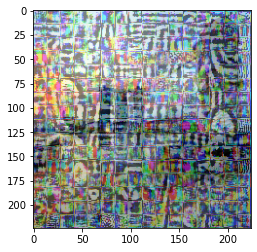

In [36]:
optimized_image = (deep_copy_tensor + change).detach().cpu().numpy()

# Scale each channel independently between 0 and 1
min_vals = optimized_image.min(axis=(2, 3), keepdims=True)
max_vals = optimized_image.max(axis=(2, 3), keepdims=True)
scaled_image = (optimized_image - min_vals) / (max_vals - min_vals)

# Plot the scaled image
plt.imshow(scaled_image.squeeze().transpose(1, 2, 0))
plt.show()

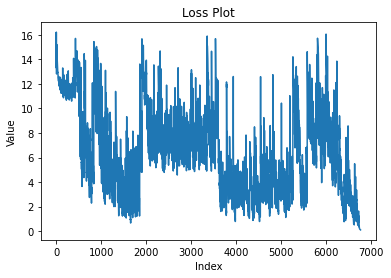

In [35]:
losses_array = [loss.detach().cpu().numpy() for loss in losses]

# Plot the array
plt.plot(np.array(losses_array))

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Loss Plot')

# Show the plot
plt.show()

In [37]:
outputs = model(**inputs)
logits = outputs.logits[0, 1:2, :]
# print('is logits nan', torch.isnan(logits).any())
# print(logits.size())
probabilities = torch.softmax(logits, dim=1)

# Assuming target_word_index is a scalar
target_prob = probabilities[0, target_word_index]

print(target_prob)

tensor(0.9051, device='cuda:0', grad_fn=<SelectBackward0>)


In [38]:
torch.argmax(probabilities, dim=1)

tensor([13599], device='cuda:0')

In [39]:
inputs['pixel_values'] = deep_copy_tensor + change

In [40]:
outputs = model.generate(**inputs)
print(processor.decode(outputs[0], skip_special_tokens=True))

/n/home09/nnayak/.local/lib/python3.8/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


 the black object in the image



In [41]:
processor.batch_decode(torch.tensor([13599]), skip_special_tokens=True)

['chair']